In [1]:
import pandas as pd
import altair as alt
from altair import datum

In [2]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# Polio cases by state from 1928-1969

**Note: Data is normalized cases per 100,000 people for each state**

- [Downloaded from visdatasets](https://visdatasets.github.io/)
- Original Retrieved from [Project Tycho](https://www.tycho.pitt.edu/); aggregated into yearly values.
- [Good article on visualizations of this data](http://www.randalolson.com/2016/03/04/revisiting-the-vaccine-visualizations/)


In [3]:
polio = pd.read_excel('data/polio_incidence_rates_united_states.xlsx', 
                      sheet_name='polio_incidence_rates')
polio.head()

,year,state,cases
0,1928,Alabama,2.39
1,1928,Alaska,0.00
2,1928,Arizona,2.61
3,1928,Arkansas,0.52
4,1928,California,5.04


### Making a simple DataFrame to hold the year of the polio vaccine introduction

We'll use this for a rule to annotate some charts

In [5]:
vacc = pd.DataFrame([{"Introduction": 1955}])

## Timeline of total incidence per year (summed over all states)

Start exploring by making a line chart that plots the sum of all the polio cases per year.

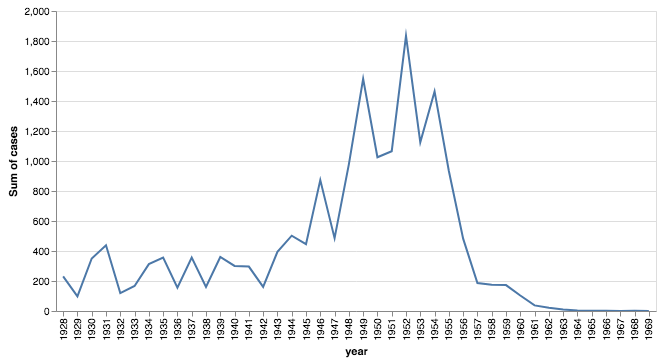

In [6]:
alt.Chart(polio).mark_line().encode(
    x = 'year:O',
    y = 'sum(cases):Q'
).properties(
    width = 600
)

## Timeline overlaying (detail) all states

We can add `detail=` to the encoding to split the data according to some categorical variable. This will make a mark for each unique entry in that category, adding a finer level of detail, without tying that variable to any other visual property like color or symbol type.

Add a `detail=` section to the previous encoding to create more detail – one line for each state.

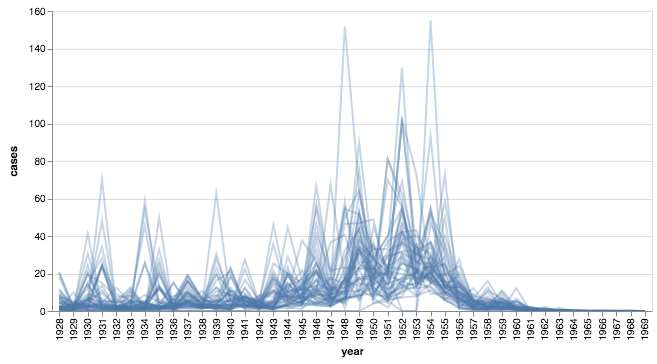

In [16]:
alt.Chart(polio).mark_line(opacity=0.3).encode(
    x = 'year:O',
    y = 'cases:Q',
    detail = 'state:N',
    tooltip = 'state:N'
).properties(
    width = 600
)

## Timeline of all states overlayed with mean cases across states

Now we'll practice layering up multiple charts using the `+` operator.

- Make the bottom layer just like your previous plot, with one line per state.
- Put over that a single line showing the **mean** number of cases per year (across all states)
- Also add rule at 1955 introduction of vaccine

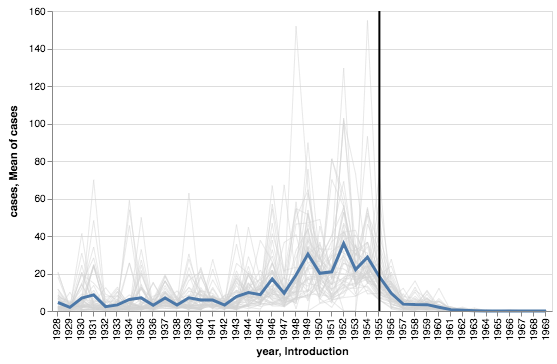

In [8]:
state_lines = alt.Chart(polio).mark_line(
    strokeWidth=0.5,
    color = 'lightgray'
).encode(
    x = 'year:O',
    y = 'cases:Q',
    detail = 'state:N'
).properties(
    width = 500
)

mean_line = alt.Chart(polio).mark_line(strokeWidth=3).encode(
    x = 'year:O',
    y = 'mean(cases):Q'
)

rule = alt.Chart(vacc).mark_rule().encode(
    x='Introduction:O',
    size = alt.value(2)
)

state_lines + mean_line + rule

## Median line with upper and lower quartile boundaries

Often data patterns are more clear if you don't show as much detail. We can use an area plot to show upper and lower quartile bounds around a (layered) median line

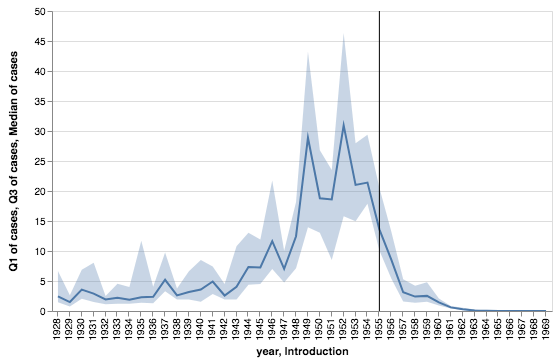

In [9]:
base = alt.Chart(polio).properties(width=500)

line = base.mark_line().encode(
    x='year:O',
    y='median(cases):Q'
)

confidence_interval = base.mark_area(opacity=0.3).encode(
    x ='year:O',
    y = 'q1(cases)',
    y2 = 'q3(cases)'
)

rule = alt.Chart(vacc).mark_rule().encode(
    x='Introduction:O'
)

confidence_interval + line + rule

## Mean line with 95% confidence intervals

Now try to do the same thing, but with the line showing the `mean` number of cases per state, and the area showing the upper and lower 95% confidence intervals.

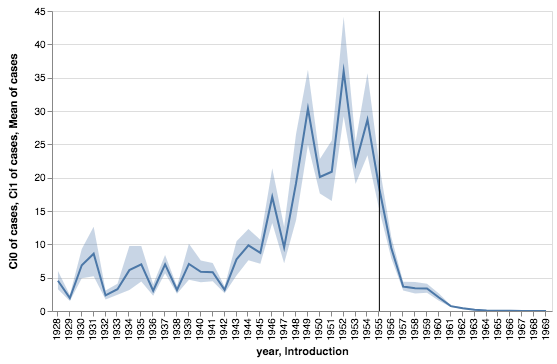

In [10]:
base = alt.Chart(polio).properties(width=500)

line = base.mark_line().encode(
    x='year:O',
    y='mean(cases):Q'
)

confidence_interval = base.mark_area(opacity=0.3).encode(
    x = 'year:O',
    y = 'ci0(cases):Q',
    y2 = 'ci1(cases):Q'
)

rule = alt.Chart(vacc).mark_rule().encode(
    x='Introduction:O'
)

confidence_interval + line + rule

## Bar chart of sum of incidents by state (over all time)

Now create a simple bar chart showing the total number of cases per state

- Try to put the state names and the bars running horizontally so it's easier to read the state names.
- By default the states will be listed alphabetically. Notice how it's hard to see the data pattern.

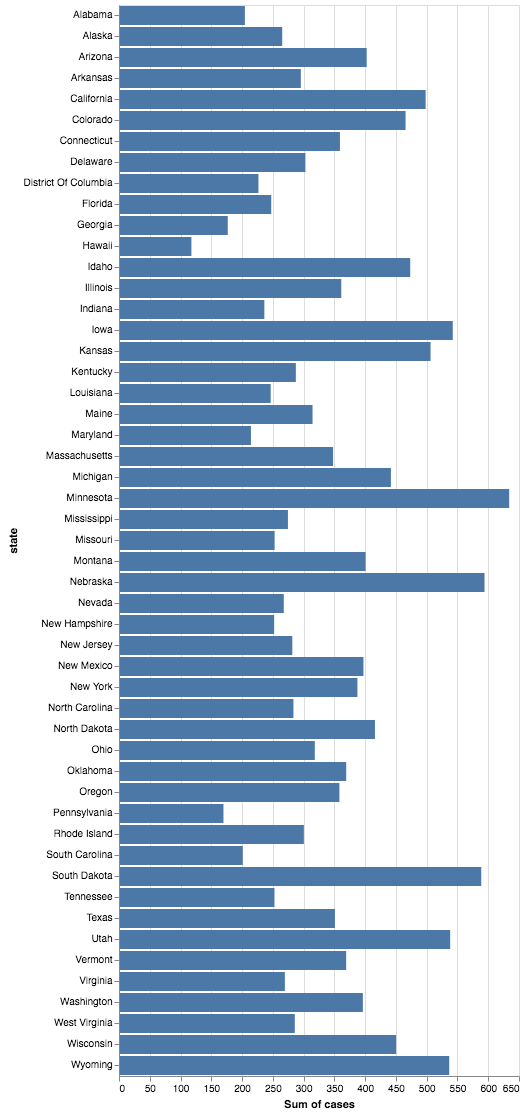

In [11]:
alt.Chart(polio).mark_bar().encode(
    x = 'sum(cases):Q',
    y = 'state:N'
)

## Sorted bar chart of sum of incidents by state (over all time)

It's better practice to sort the bars (descending) by their length. To do that we need to change the specification for the y-axis to sort the categorical variable.

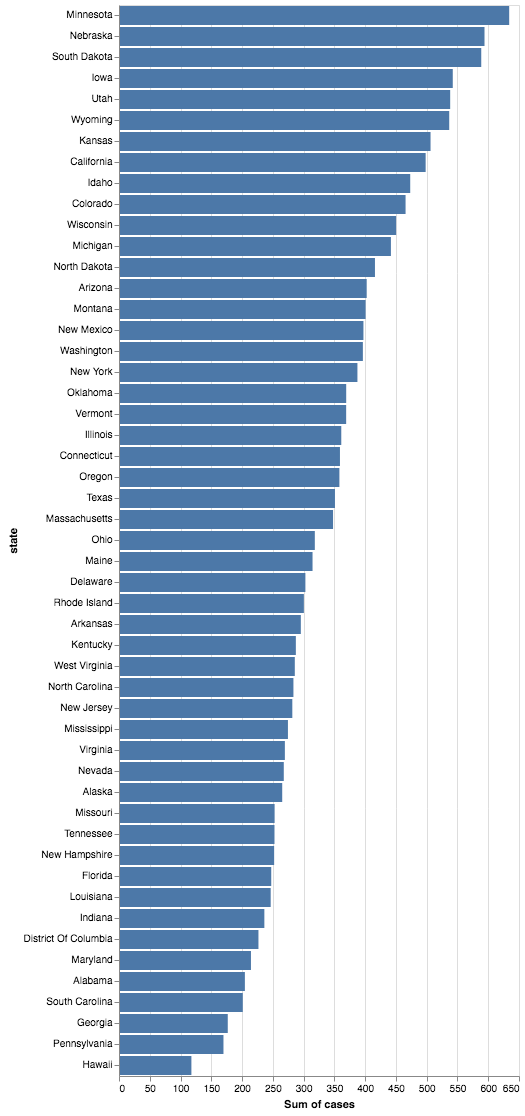

In [20]:
alt.Chart(polio).mark_bar().encode(
    x = 'sum(cases):Q',
    y = alt.Y('state:N',
            sort=alt.EncodingSortField(
                field="cases",
                op="sum",
                order="descending"))
)

## Top 10 bar chart of summed cases per state, sorted (descending) by number of cases

`transform_window()` is currently very poorly documented in Altair. It's purpose is to do things like running averages and rank calculations. In Tableau, these are usually "table calculations".

- Here I [pulled from this example](https://github.com/altair-viz/altair/blob/master/altair/examples/top_k_letters.py) to calculate the top 10 states
- Note that since I needed to use the sum of cases in multiple places I put it in a `transform_aggregate()` section

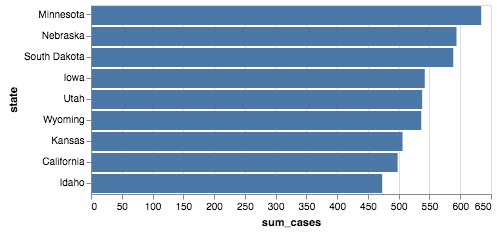

In [17]:
alt.Chart(polio).mark_bar().encode(
    x = 'sum_cases:Q',
    y = alt.Y('state:N',
            sort=alt.EncodingSortField(
                field="sum_cases",
                op="sum",
                order="descending")
    )
).transform_aggregate(
    sum_cases='sum(cases)',
    groupby=['state']
).transform_window(
    rank = 'rank(sum_cases)',
    sort=[alt.SortField('sum_cases', order='descending')]
).transform_filter(
    alt.datum.rank < 10
)

## Heatmap of cases by state and year

*(Note: To see the trend more clearly, limit the color scale domain from 0-50.)*

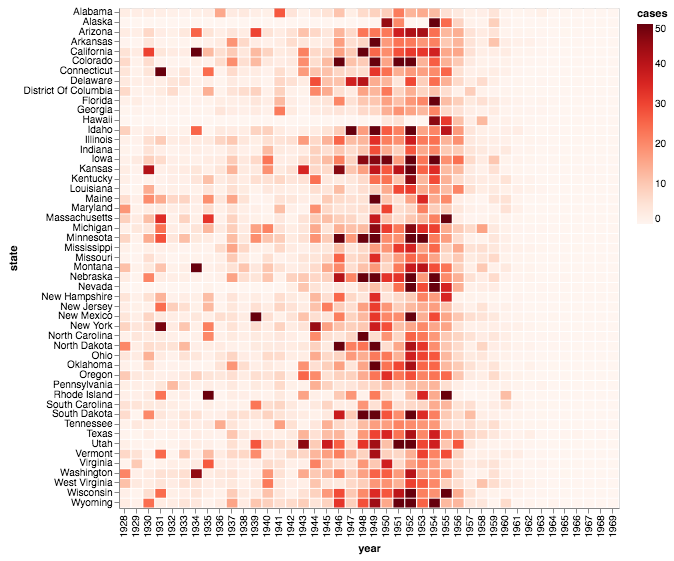

In [13]:
alt.Chart(polio).mark_rect().encode(
    x = 'year:O',
    y = 'state:N',
    color = alt.Color('cases:Q', scale=alt.Scale(scheme='reds', domain=[0,50]))
).properties(
    width = 500,
    height = 500
)

## Heatmap with states sorted by sum of cases

Now again 

- sort the states by the sum of the number of cases (over all years)
- add a rule at the year when the vaccine was introduced

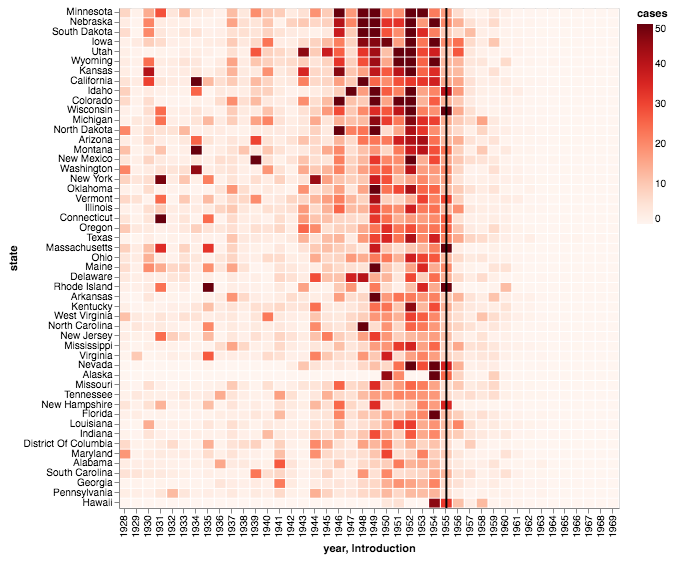

In [14]:
heatmap = alt.Chart(polio).mark_rect().encode(
    x = 'year:O',
    y = alt.Y('state',
            sort=alt.EncodingSortField(
                field="cases",
                op="sum",
                order="descending")
    ),
    color = alt.Color('cases:Q', scale=alt.Scale(scheme='reds', domain=[0,50]))
).properties(
    width = 500,
    height = 500
)

rule = alt.Chart(vacc).mark_rule().encode(
    x='Introduction:O',
    size=alt.value(2)
)

heatmap + rule

## Maps

In [21]:
states = pd.read_excel('data/polio_incidence_rates_united_states.xlsx', sheet_name='state_locations')
states.head()

,state,abbrev,latitude,longitude
0,Alabama,AL,32.601011,-86.680736
1,Alaska,AK,61.302501,-158.775020
2,Arizona,AZ,34.168219,-111.930907
3,Arkansas,AR,34.751928,-92.131378
4,California,CA,37.271875,-119.270415
